# Import the package

In [1]:
from datetime import datetime
import lightgbm as lgb
from lightgbm import LGBMClassifier
from lightgbm import plot_importance
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.pyplot import MultipleLocator
%matplotlib inline
import numpy as np
from numpy import mean
from numpy import std
from numpy import sort
import pandas as pd
from pandas.core.frame import DataFrame
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics
from sklearn.metrics import f1_score  
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix,roc_curve,roc_auc_score,accuracy_score, plot_confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import log_loss
import seaborn as sns
from time import time
import pprint
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper,DeltaYStopper
from skopt.space import Real,Categorical,Integer
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
import joblib

# Dataset

In [2]:
CTGData=pd.read_csv('CTG.csv')

In [3]:
CTGData3=CTGData.copy()
X=CTGData3.drop(labels=['CLASS','NSP'],axis=1)

y=CTGData3['NSP'].values
y = LabelEncoder().fit_transform(y)

In [4]:
CTGData3.shape

(2126, 23)

In [5]:
#stanardilization
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(X)
X=scaler.transform(X)

In [6]:
#split train dataset and test dataset
X_train, X_test,y_train,y_test= train_test_split(X,y,test_size=0.2,random_state=42)



# Feature selection

## Light GBM OPT

In [7]:
gbm =lgbm_params=LGBMClassifier(boosting_type='gbdt',objective ='multiclass',max_depth=4, num_leaves=300,
                                learning_rate=0.01,n_estimators=150)


In [8]:

score =cross_val_score(gbm, X_train, y_train, cv=5,scoring='neg_log_loss').mean()
print('cross validation loss at trainingset:',score) 

gbm.fit(X_train, y_train)
prob_gbm=gbm.predict_proba(X_test)
loss_gbm=log_loss(y_test,prob_gbm)
print('gbm at testset accuracy:',gbm.score(X_test,y_test)) 
print('loss at testset annually calculated :',loss_gbm)  

cross validation loss at trainingset: -0.2286611210826261
gbm at testset accuracy: 0.931924882629108
loss at testset annually calculated : 0.22886218351927498


###  Bayes OPT hyperparameter searching

In [9]:
start=datetime.now()

# Bayers搜索，参数优化
BayerLgbmopt = BayesSearchCV(
     gbm,
     {         
        'learning_rate': (0.005,0.01,0.001), 
        'n_estimators': (100,300), 
  
        'max_depth': (3,8), 
        'num_leaves':(8, 170),
         
        'subsample': (0.5,0.8), 
        'colsample_bytree': (0.5,0.8)
       
    } ,
     n_iter=50,
     cv=5
     ,scoring="neg_log_loss"
    ,random_state=42
    ,n_points=2
)
BayerLgbmopt.fit(X_train, y_train)

stop=datetime.now()

execution_time_lgbm0=(stop-start)
print(execution_time_lgbm0)

0:01:55.339326


In [10]:
print('Best parameters found by Bayes search are:', BayerLgbmopt.best_params_)
print("val. score: %s" % BayerLgbmopt.best_score_)
print("test score: %s" % BayerLgbmopt.score(X_test, y_test))

Best parameters found by Bayes search are: OrderedDict([('colsample_bytree', 0.7467406407942192), ('learning_rate', 0.01), ('max_depth', 8), ('n_estimators', 299), ('num_leaves', 113), ('subsample', 0.5518308135081977)])
val. score: -0.15771527516910397
test score: -0.14893452688737022


### Build the modle with the OPT hyperparameter

In [11]:
lgbm=LGBMClassifier(boosting_type='gbdt',objective ='multiclass',
                                 max_depth=8, num_leaves=170,
                                learning_rate=0.01,n_estimators=300,
                                colsample_bytree= 0.6636,subsample= 0.8)

## RFE Feature selection with the OPT model

0.2975353553669229 20
[0.6547193952501609, 0.6645077636069525, 0.597192905260578, 0.5149569268524561, 0.49136698809361745, 0.4685209739645277, 0.4726013521925962, 0.36511006905513854, 0.3498340985022357, 0.3482678279012593, 0.34486504128190465, 0.3371049117325059, 0.34592498636136665, 0.34587269888506744, 0.3338263467473812, 0.3120066230883614, 0.3016926335358424, 0.3096439542846287, 0.3083801809288104, 0.2975353553669229, 0.2975353553669229]


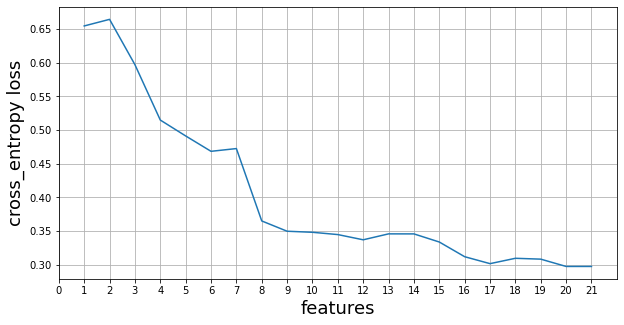

datetime.timedelta(seconds=191, microseconds=532017)

In [12]:
# 递归特征消除法和曲线图选取最优特征数量 
start=datetime.now()
score = []                                                            # 建立列表
for i in range(1,22, 1):
    X_wrapper=RFE(lgbm, n_features_to_select=i, step=1).fit_transform(X, y)      # 最优特征 
    once = cross_val_score(lgbm, X_wrapper, y, cv=5,scoring='neg_log_loss').mean()                      # 交叉验证
    score.append(once)                                                           # 交叉验证结果保存到列表
cross_entropy_loss=[j * -1 for j in score]

print(min(cross_entropy_loss), (cross_entropy_loss.index(min(cross_entropy_loss))*1)+1)                                 # 输出最优分类结果和对应的特征数量
print(cross_entropy_loss)
plt.figure(figsize=[10, 5])
plt.plot(range(1, 22, 1), cross_entropy_loss)
plt.xticks(range(0, 22))
plt.xlabel(u'features', fontsize=18)
plt.ylabel(u'cross_entropy loss', fontsize=18)
plt.grid()
plt.show()
stop=datetime.now()

execution_time_lgbm1=(stop-start)
execution_time_lgbm1

In [13]:
# 4.递归特征消除法
start=datetime.now()
selector = RFE(lgbm, n_features_to_select=20, step=1).fit(X, y)       # n_features_to_select表示筛选最终特征数量，step表示每次排除一个特征
selector.support_.sum()
print(selector.ranking_)                                             # 特征排除排序
print(selector.n_features_)                                          # 选择特征数量
X_wrapper_20 = selector.transform(X)                                   # 最优特征


stop=datetime.now()

execution_time_lgbm2=(stop-start)
execution_time_lgbm2

[1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
20


datetime.timedelta(seconds=1, microseconds=335788)

## Save the selected feature to csv file

In [14]:
index20=selector.get_support(indices=True)
index20

array([ 0,  1,  2,  3,  4,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20], dtype=int64)

In [15]:
idx=[  0,  1,  2,  3,  4,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20]
A=CTGData3.iloc[ :,idx]
A['label'] = y
A

,LB,AC,FM,UC,DL,DP,ASTV,MSTV,ALTV,MLTV,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,label
0,120,0.000000,0.000000,0.000000,0.000000,0.0,73,0.5,43,2.4,...,62,126,2,0,120,137,121,73,1,1
1,132,0.006380,0.000000,0.006380,0.003190,0.0,17,2.1,0,10.4,...,68,198,6,1,141,136,140,12,0,0
2,133,0.003322,0.000000,0.008306,0.003322,0.0,16,2.1,0,13.4,...,68,198,5,1,141,135,138,13,0,0
3,134,0.002561,0.000000,0.007682,0.002561,0.0,16,2.4,0,23.0,...,53,170,11,0,137,134,137,13,1,0
4,132,0.006515,0.000000,0.008143,0.000000,0.0,16,2.4,0,19.9,...,53,170,9,0,137,136,138,11,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,140,0.000000,0.000000,0.007426,0.000000,0.0,79,0.2,25,7.2,...,137,177,4,0,153,150,152,2,0,1
2122,140,0.000775,0.000000,0.006971,0.000000,0.0,78,0.4,22,7.1,...,103,169,6,0,152,148,151,3,1,1
2123,140,0.000980,0.000000,0.006863,0.000000,0.0,79,0.4,20,6.1,...,103,170,5,0,153,148,152,4,1,1
2124,140,0.000679,0.000000,0.006110,0.000000,0.0,78,0.4,27,7.0,...,103,169,6,0,152,147,151,4,1,1


In [16]:
A.to_csv('CTGNSP selected 20 features.csv',index=False)

In [17]:
features20=pd.read_csv('CTGNSP selected 20 features.csv')
# ,index_col=0)
features20.head()

,LB,AC,FM,UC,DL,DP,ASTV,MSTV,ALTV,MLTV,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,label
0,120,0.000000,0.0,0.000000,0.000000,0.0,73,0.5,43,2.4,...,62,126,2,0,120,137,121,73,1,1
1,132,0.006380,0.0,0.006380,0.003190,0.0,17,2.1,0,10.4,...,68,198,6,1,141,136,140,12,0,0
2,133,0.003322,0.0,0.008306,0.003322,0.0,16,2.1,0,13.4,...,68,198,5,1,141,135,138,13,0,0
3,134,0.002561,0.0,0.007682,0.002561,0.0,16,2.4,0,23.0,...,53,170,11,0,137,134,137,13,1,0
4,132,0.006515,0.0,0.008143,0.000000,0.0,16,2.4,0,19.9,...,53,170,9,0,137,136,138,11,1,0


In [18]:
features20.shape

(2126, 21)

In [19]:
X1=features20.drop(labels=['label'],axis=1)

y1=features20['label'].values

In [20]:
scaler=StandardScaler()
scaler.fit(X1)
X1=scaler.transform(X1)
#split train dataset and test dataset
X1_train, X1_test,y1_train,y1_test= train_test_split(X1,y1,test_size=0.2, shuffle = True,stratify=y1,random_state=42)

In [21]:
lgbm.fit(X1_train, y1_train)

LGBMClassifier(colsample_bytree=0.6636, learning_rate=0.01, max_depth=8,
               n_estimators=300, num_leaves=170, objective='multiclass',
               subsample=0.8)

In [112]:
y_pred_lgbm1=lgbm.predict((X1_test))
y_prob_lgbm1=lgbm.predict_proba((X1_test))
print("Accuracy score with LGBM is: ",accuracy_score(y1_test, y_pred_lgbm1))
print("F1 score with LGBM is: ",f1_score(y1_test, y_pred_lgbm1,average='micro'))
print("ROC_AUC score with LGBM is: ", roc_auc_score(y1_test,y_prob_lgbm1,multi_class='ovr',labels=np.unique(y1_test)))
print("Cross entropy loss score with LGBM is: ",log_loss(y1_test,y_prob_lgbm1))


Accuracy score with LGBM is:  0.9295774647887324
F1 score with LGBM is:  0.9295774647887324
ROC_AUC score with LGBM is:  0.9844112390072315
Cross entropy loss score with LGBM is:  0.17917574280458173


## Explore feature importance

In [100]:
lgbm.feature_importances_

array([1814, 1484, 1536, 1774,  664, 1321, 2818, 1666, 2316, 1675, 1734,
       1455, 1453,  794,  102, 1570, 2129, 1277, 1302,  266])

In [101]:
featureName=features20.columns[:-1]

<BarContainer object of 20 artists>

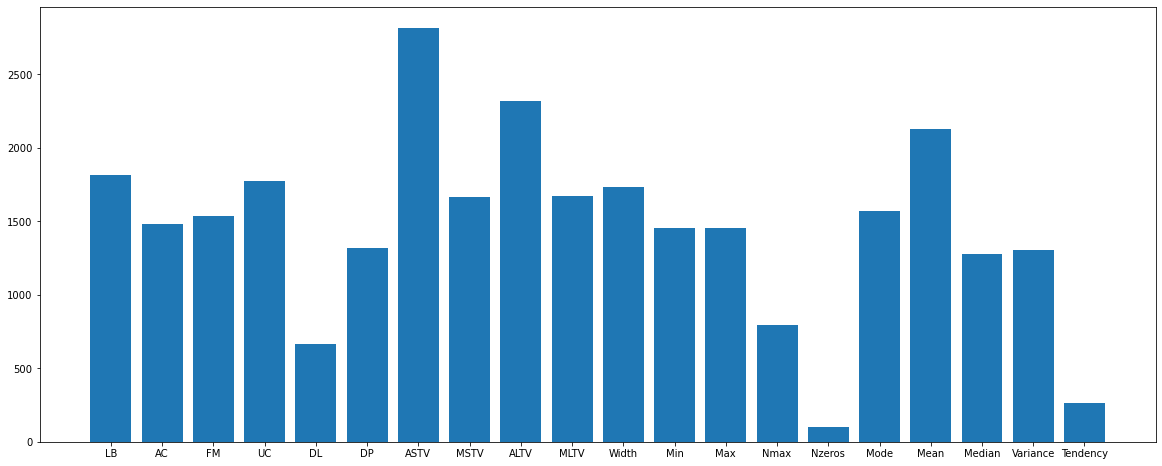

In [102]:
plt.figure(figsize=(20,8))
plt.bar(featureName,lgbm.feature_importances_)

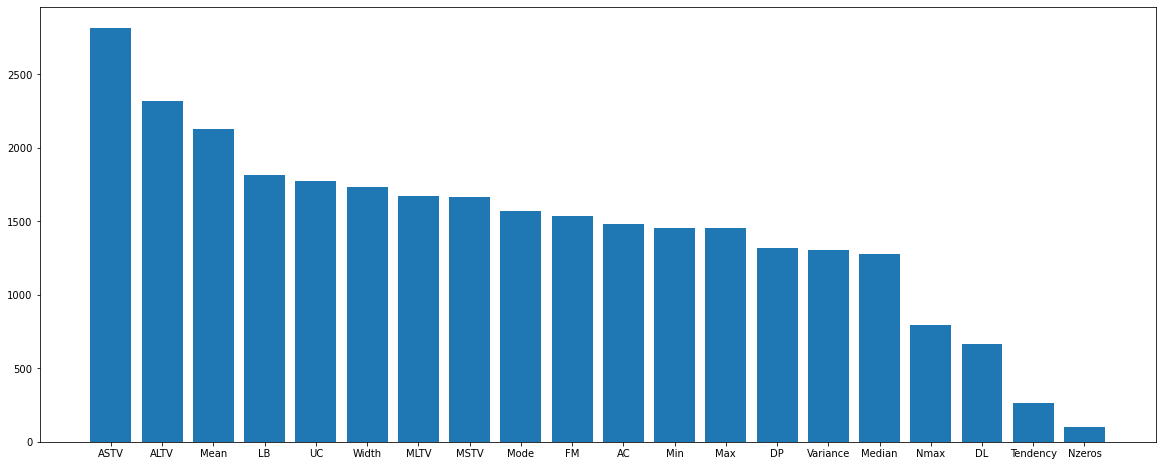

In [103]:
plt.figure(figsize=(20,8))
feature_important = pd.Series(lgbm.feature_importances_, index =featureName).sort_values(ascending=False)
plt.bar(feature_important.index, feature_important)
plt.show()

In [106]:
NSPData1=A[A['label']==0]
NSPData2=A[A['label']==1]
NSPData3=A[A['label']==2]


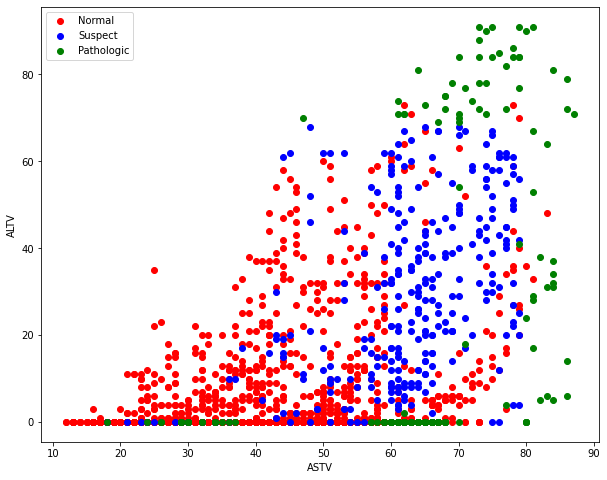

In [109]:
plt.figure(figsize=(10,8))
plt.scatter(NSPData1['ASTV'],NSPData1['ALTV'],c='red', label='Normal')
plt.scatter(NSPData2['ASTV'],NSPData2['ALTV'],c='blue', label='Suspect')
plt.scatter(NSPData3['ASTV'],NSPData3['ALTV'],c='green', label='Pathologic')

plt.xlabel('ASTV')
plt.ylabel('ALTV')
plt.legend(loc=2)
plt.show()

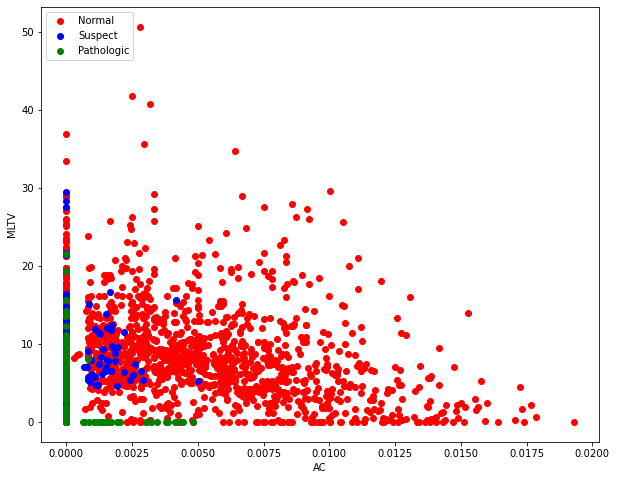

In [110]:
plt.figure(figsize=(10,8))
plt.scatter(NSPData1['AC'],NSPData1['MLTV'],c='red', label='Normal')
plt.scatter(NSPData2['AC'],NSPData2['MLTV'],c='blue', label='Suspect')
plt.scatter(NSPData3['AC'],NSPData3['MLTV'],c='green', label='Pathologic')

plt.xlabel('AC')
plt.ylabel('MLTV')
plt.legend(loc=2)
plt.show()

Accuracy score with LGBM is:  0.9295774647887324
F1 score with LGBM is:  0.9295774647887324
ROC_AUC score with LGBM is:  0.9844112390072315
Cross entropy loss score with LGBM is:  0.17917574280458173


 # 2nd OPT for each model after RFE

## Light GBM

In [23]:
start=datetime.now()

# Bayers搜索，参数优化
BayerLgbmopt1 = BayesSearchCV(
     lgbm,
     {         
        'learning_rate': (0.005,0.01,0.001), 
        'n_estimators': (100,300), 
  
        'max_depth': (3,8), 
        'num_leaves':(8, 170),
         
        'subsample': (0.5,0.8), 
        'colsample_bytree': (0.5,0.8)
       
    } ,
     n_iter=50,
     cv=5
     ,scoring="neg_log_loss"
    ,random_state=42
    ,n_points=2
)
BayerLgbmopt1.fit(X1_train, y1_train)

stop=datetime.now()
execution_time_lgbm3=(stop-start)
print(execution_time_lgbm3)

0:02:34.181163


In [24]:
print('Best parameters found by Bayes search are:', BayerLgbmopt1.best_params_)
print("val. score: %s" % BayerLgbmopt1.best_score_)
print("test score: %s" % BayerLgbmopt1.score(X1_test, y1_test))

Best parameters found by Bayes search are: OrderedDict([('colsample_bytree', 0.8), ('learning_rate', 0.01), ('max_depth', 8), ('n_estimators', 300), ('num_leaves', 170), ('subsample', 0.8)])
val. score: -0.14793525408062694
test score: -0.1832007685672168


In [46]:
lgbm1=LGBMClassifier(boosting_type='gbdt',objective ='multiclass',
                                 max_depth=8, num_leaves=170,
                                learning_rate=0.01,n_estimators=300,
                                colsample_bytree= 0.8,subsample= 0.8)

In [47]:
lgbm_ctgnsp=lgbm1.fit(X1_train,y1_train)

In [48]:
y_pred_lgbm1=lgbm1.predict((X1_test))
y_prob_lgbm1=lgbm1.predict_proba((X1_test))
print("Accuracy score with LGBM is: ",accuracy_score(y1_test, y_pred_lgbm1))
print("F1 score with LGBM is: ",f1_score(y1_test, y_pred_lgbm1,average='micro'))
print("ROC_AUC score with LGBM is: ", roc_auc_score(y1_test,y_prob_lgbm1,multi_class='ovr',labels=np.unique(y1_test)))
print("Cross entropy loss score with LGBM is: ",log_loss(y1_test,y_prob_lgbm1))


Accuracy score with LGBM is:  0.931924882629108
F1 score with LGBM is:  0.931924882629108
ROC_AUC score with LGBM is:  0.9824944554519801
Cross entropy loss score with LGBM is:  0.1832007685672168


In [49]:
lgbm_accuracy='%.4f'%accuracy_score(y1_test, y_pred_lgbm1)
lgbm_f1='%.4f'%f1_score(y1_test, y_pred_lgbm1,average='micro')
lgbm_roc_auc='%.4f'% roc_auc_score(y1_test,y_prob_lgbm1,multi_class='ovr',labels=np.unique(y1_test))
lgbm_loss='%.4f'%log_loss(y1_test,y_prob_lgbm1)
print(lgbm_accuracy)
print(lgbm_f1)
print(lgbm_roc_auc)
print(lgbm_loss)

0.9319
0.9319
0.9825
0.1832


In [50]:
start=datetime.now()
accuracy_score_20 =cross_val_score(lgbm1, X1_train, y1_train, cv=5,scoring='accuracy').mean()
F1_score_20 =cross_val_score(lgbm1, X1_train, y1_train, cv=5,scoring='f1_micro').mean()
roc_auc_score_20 =cross_val_score(lgbm1, X1_train, y1_train, cv=5,scoring='roc_auc_ovr').mean()
neg_loss_score_20 =cross_val_score(lgbm1, X1_train, y1_train, cv=5,scoring='neg_log_loss').mean()
stop=datetime.now()

execution_time_lgbm4=(stop-start)/20
execution_time_lgbm4

print("accuracy 20  feature:",accuracy_score_20)
print('F1 score 20  feature:',F1_score_20)
print('roc_auc 20  feature:',roc_auc_score_20)
print("cross entropy loss 20  feature:",neg_loss_score_20)


accuracy 20  feature: 0.9488235294117647
F1 score 20  feature: 0.9488235294117647
roc_auc 20  feature: 0.9872886454457237
cross entropy loss 20  feature: -0.14793525408062694


In [51]:
execution_time_lgbm4

datetime.timedelta(microseconds=554875)

In [52]:
training_time_lgbm=execution_time_lgbm4.total_seconds()
training_time_lgbm='%.4f'%training_time_lgbm
print(training_time_lgbm)

0.5549


In [53]:
# save the model
joblib.dump(lgbm_ctgnsp,'lgbm_ctgnsp.model')

['lgbm_ctgnsp.model']

In [54]:
rflgbm_CTGNSP=joblib.load('lgbm_ctgnsp.model')
   #应用模型进行预测
resultlgmb=rflgbm_CTGNSP.score(X1_test,y1_test)

In [55]:
resultlgmb

0.931924882629108

## SVM & Bayes Optimization

In [35]:
svc = SVC(random_state=42
           ,C= 8.5385
           ,kernel='rbf'
           ,degree= 7
          ,gamma="scale"
          , probability=True)
accuracies = cross_val_score(svc,X1_train,y1_train,cv=5)
svc.fit(X1_train,y1_train)
svc.predict(X1_test)
print("Train Score:",np.mean(accuracies))
print("Test Score:",svc.score(X1_test,y1_test))

Train Score: 0.9294117647058824
Test Score: 0.9131455399061033


In [36]:
pred=svc.predict(X1_test)
prob=svc.predict_proba(X1_test)
print("Test loss Score:",log_loss(y1_test,prob))

Test loss Score: 0.21596376243264967


In [37]:
svc.fit(X_train,y_train)
svc.predict(X_test)
print("Train Score:",np.mean(accuracies))
print("Test Score:",svc.score(X_test,y_test))

Train Score: 0.9294117647058824
Test Score: 0.9272300469483568


In [38]:
start=datetime.now()                
# log-uniform: understand as search over p = exp(x) by varying x
BayerSvmopt = BayesSearchCV(
    SVC(probability=True, random_state=42,
          C=10
           ,degree= 1
           ,gamma= 0.0013
           ,kernel='rbf'
#            ,random_state=42
# #           ,gamma="scale"
#           , probability=True
    ),
    {
        
#        'kernel': ['linear', 'poly', 'rbf'],
#         'C':(1, 10),     
        'gamma': (0.01, 1),

    },
 
    n_iter=50,
    cv=5
    ,scoring="neg_log_loss"
    ,random_state=42
    ,n_points=2
)

BayerSvmopt.fit(X1_train, y1_train)
stop=datetime.now()

execution_time_svm1=(stop-start)
execution_time_svm1


datetime.timedelta(seconds=138, microseconds=343123)

In [39]:
print("best params: %s" % str(BayerSvmopt.best_params_))


print("val. score: %s" % BayerSvmopt.best_score_)
print("test score: %s" % BayerSvmopt.score(X1_test, y1_test))

best params: OrderedDict([('gamma', 0.04774380456123877)])
val. score: -0.19413307495813142
test score: -0.21452155198861358


In [56]:
svc1=SVC(probability=True, random_state=42,
          C=10
           ,degree= 1
           ,gamma= 0.0477
           ,kernel='rbf')

In [57]:
svc1.fit(X1_train,y1_train)
svc1.score(X1_test,y1_test)

0.9107981220657277

In [119]:
start=datetime.now()
accuracy_score_20_svm =cross_val_score(svc1, X1_train, y1_train, cv=5,scoring='accuracy').mean()
F1_score_20_svm =cross_val_score(svc1, X1_train, y1_train, cv=5,scoring='f1_micro').mean()
roc_auc_score_20_svm =cross_val_score(svc1, X1_train, y1_train, cv=5,scoring='roc_auc_ovr').mean()
neg_loss_score_20_svm =cross_val_score(svc1, X1_train, y1_train, cv=5,scoring='neg_log_loss').mean()

stop=datetime.now()
execution_time_svm0=(stop-start)/20
execution_time_svm0

print("accuracy 20  feature:",accuracy_score_20_svm)
print('F1 score 20  feature:',F1_score_20_svm)
print('roc_auc 20  feature:',roc_auc_score_20_svm)
print("cross entropy loss 20  feature:",neg_loss_score_20_svm)

accuracy 20  feature: 0.931764705882353
F1 score 20  feature: 0.931764705882353
roc_auc 20  feature: 0.9781116472936191
cross entropy loss 20  feature: -0.19413780228583408


In [120]:
training_time_svm0=execution_time_svm0.total_seconds()
training_time_svm0='%.4f'%training_time_svm0
print(training_time_svm0)

0.1998


In [125]:
svc2 = SVC(C= 8.5385
           ,kernel='rbf'
           ,degree= 7
#            ,gamma= 1.584
          ,gamma=0.07
           ,random_state=42
          , probability=True
          )

In [126]:

start=datetime.now()
svc_ctgnsp=svc2.fit(X1_train,y1_train)
stop=datetime.now()
execution_time_svc='%.4f'%(stop-start).total_seconds()

print(execution_time_svc)

0.3007


In [127]:
start=datetime.now()
accuracy_score_20_svm =cross_val_score(svc2, X1_train, y1_train, cv=5,scoring='accuracy').mean()
F1_score_20_svm =cross_val_score(svc2, X1_train, y1_train, cv=5,scoring='f1_micro').mean()
roc_auc_score_20_svm =cross_val_score(svc2, X1_train, y1_train, cv=5,scoring='roc_auc_ovr').mean()
neg_loss_score_20_svm =cross_val_score(svc2, X1_train, y1_train, cv=5,scoring='neg_log_loss').mean()

stop=datetime.now()
execution_time_svm=(stop-start)/20
execution_time_svm

print("accuracy 20  feature:",accuracy_score_20_svm)
print('F1 score 20  feature:',F1_score_20_svm)
print('roc_auc 20  feature:',roc_auc_score_20_svm)
print("cross entropy loss 20  feature:",neg_loss_score_20_svm)

accuracy 20  feature: 0.9270588235294118
F1 score 20  feature: 0.9270588235294118
roc_auc 20  feature: 0.9764730865709726
cross entropy loss 20  feature: -0.19724468696020772


In [128]:
training_time_svm=execution_time_svm.total_seconds()
training_time_svm='%.4f'%training_time_svm
print(training_time_svm)

0.2290


In [129]:
y_pred_svc1=svc2.predict(X1_test)
y_prob_svc1=svc2.predict_proba(X1_test)

In [130]:

svc_accuracy='%.4f'%accuracy_score(y1_test, y_pred_svc1)
svc_f1='%.4f'%f1_score(y1_test, y_pred_svc1,average='micro')
svc_roc_auc='%.4f'% roc_auc_score(y1_test,y_prob_svc1,multi_class='ovr',labels=np.unique(y1_test))
svc_loss='%.4f'%log_loss(y1_test,y_prob_svc1)
print(svc_accuracy)
print(svc_f1)
print(svc_roc_auc)
print(svc_loss)

0.9225
0.9225
0.9739
0.2152


### Comparing with other hyperparameter

In [68]:
svc4 = SVC(C= 0.016,degree= 6,gamma= 1.584,kernel='linear',random_state=42
#           ,gamma="scale"
          , probability=True)

In [69]:
svc4.fit(X1_train,y1_train)
svc4.score(X1_test,y1_test)

0.8873239436619719

In [74]:
svc3 = SVC(C= 100
           ,kernel='rbf'
#            ,degree= 7
#            ,gamma= 1.584
          ,gamma=0.01
           ,random_state=42
          , probability=True
          )

In [75]:
svc3.fit(X1_train,y1_train)
svc3.score(X1_test,y1_test)

0.9061032863849765

In [131]:
  #保存模型
joblib.dump(svc_ctgnsp,'svc_ctgnsp.model')

['svc_ctgnsp.model']

In [132]:
#加载模型
RFsvc=joblib.load('svc_ctgnsp.model')
   #应用模型进行预测
resultsvc=RFsvc.score(X1_test,y1_test)

In [133]:
resultsvc

0.9225352112676056

## Random Forest

In [84]:
rf = RFC(random_state=42)


Bayesrfopt = BayesSearchCV(
   rf,
    {   
    'n_estimators': [50,100,150],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,25,None],
    'criterion' :['gini', 'entropy']
    },
    n_iter=50,
    cv=5,
    scoring="neg_log_loss"
    ,random_state=42
    ,n_points=2
)

Bayesrfopt.fit(X_train, y_train)
print('Best parameters found by grid search are:', Bayesrfopt.best_params_)

Best parameters found by grid search are: OrderedDict([('criterion', 'entropy'), ('max_depth', 15), ('max_features', 'log2'), ('n_estimators', 150)])


In [85]:
print("val. score: %s" % Bayesrfopt.best_score_)
print("test score: %s" % Bayesrfopt.score(X_test, y_test))

val. score: -0.1692701664792431
test score: -0.16207517807710756


In [86]:
rf1 = RFC(random_state=42, max_features='log2', n_estimators= 150,
                                     max_depth=15, 
                                     criterion='entropy')

In [87]:
start=datetime.now()
rf1.fit(X_train,y_train)
stop=datetime.now()
execution_time_rf=(stop-start)
execution_time_rf
training_time_rf0=execution_time_rf.total_seconds()
training_time_rf0='%.4f'%training_time_rf0
print(training_time_rf0)

0.4388


In [88]:
accuracies = cross_val_score(rf1,X1_train,y1_train,cv=5)
loss=cross_val_score(rf1,X1_train,y1_train,cv=5,scoring='neg_log_loss')
rf1.fit(X_train,y_train)
pred=rf1.predict(X_test)
prob=rf1.predict_proba(X_test)
print("CVTrain loss Score:",np.mean(loss))
print("CVTrain accuracy Score:",np.mean(accuracies))
print("Test accuracy Score:",rf1.score(X_test,y_test))
print("Test loss Score:",log_loss(y_test,prob))

CVTrain loss Score: -0.17598935270976362
CVTrain accuracy Score: 0.943529411764706
Test accuracy Score: 0.9483568075117371
Test loss Score: 0.16207517807710756


In [98]:
rf1.fit(X1_train,y1_train)
rf1.score(X1_test,y1_test)

0.931924882629108

In [89]:
start=datetime.now()
Bayesrfopt1 = BayesSearchCV(
   rf1,
    {   
    'n_estimators': [50,100,150],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,25,None],
    'criterion' :['gini', 'entropy']
    },
    n_iter=50,
    cv=5,
    scoring="neg_log_loss"
    ,random_state=42
    ,n_points=2
)

Bayesrfopt1.fit(X1_train, y1_train)

stop=datetime.now()
execution_time_rf0=(stop-start)
print(execution_time_rf0)
print('Best parameters found by grid search are:', Bayesrfopt1.best_params_)

0:01:45.828564
Best parameters found by grid search are: OrderedDict([('criterion', 'entropy'), ('max_depth', 12), ('max_features', 'sqrt'), ('n_estimators', 100)])


In [90]:

print("val. score: %s" % Bayesrfopt1.best_score_)
print("test score: %s" % Bayesrfopt1.score(X1_test, y1_test))

val. score: -0.15870577382751713
test score: -0.18164782887922457


In [91]:
rf2= RFC(random_state=42, max_features='sqrt', n_estimators= 100,
                                     max_depth=12, 
                                     criterion='entropy')


In [92]:
start=datetime.now()
accuracy_score_10_rf =cross_val_score(rf2, X1_train, y1_train, cv=5,scoring='accuracy').mean()
F1_score_10_rf =cross_val_score(rf2, X1_train, y1_train, cv=5,scoring='f1_micro').mean()
roc_auc_score_10_rf =cross_val_score(rf2, X1_train, y1_train, cv=5,scoring='roc_auc_ovr').mean()
neg_loss_score_10_rf =cross_val_score(rf2, X1_train, y1_train, cv=5,scoring='neg_log_loss').mean()

stop=datetime.now()
execution_time_rf=(stop-start)/20
execution_time_rf

print("accuracy 10  feature:",accuracy_score_10_rf)
print('F1 score 10  feature:',F1_score_10_rf)
print('roc_auc 10  feature:',roc_auc_score_10_rf)
print("cross entropy loss 10  feature:",neg_loss_score_10_rf)

accuracy 10  feature: 0.9441176470588235
F1 score 10  feature: 0.9441176470588235
roc_auc 10  feature: 0.9875042361650694
cross entropy loss 10  feature: -0.15870577382751713


In [93]:
training_time_rf=execution_time_rf.total_seconds()
training_time_rf='%.4f'%training_time_rf
print(training_time_rf)

0.2522


In [94]:
rf_ctgnsp=rf2.fit(X1_train,y1_train)
y_pred_rf2=rf2.predict(X1_test)
y_prob_rf2=rf2.predict_proba(X1_test)

print("Accuracy score with LGBM is: ",accuracy_score(y1_test, y_pred_rf2))
print("F1 score with LGBM is: ",f1_score(y1_test, y_pred_rf2,average='micro'))
print("ROC_AUC score with LGBM is: ", roc_auc_score(y1_test,y_prob_rf2,multi_class='ovr',labels=np.unique(y1_test)))
print("Cross entropy loss score with LGBM is: ",log_loss(y1_test,y_prob_rf2))


rf_accuracy='%.4f'%accuracy_score(y1_test, y_pred_rf2)
rf_f1='%.4f'%f1_score(y1_test, y_pred_rf2,average='micro')
rf_roc_auc='%.4f'% roc_auc_score(y1_test,y_prob_rf2,multi_class='ovr',labels=np.unique(y1_test))
rf_loss='%.4f'%log_loss(y1_test,y_prob_rf2)
print(rf_accuracy)
print(rf_f1)
print(rf_roc_auc)
print(rf_loss)

Accuracy score with LGBM is:  0.9389671361502347
F1 score with LGBM is:  0.9389671361502347
ROC_AUC score with LGBM is:  0.9833181298995961
Cross entropy loss score with LGBM is:  0.18164782887922457
0.9390
0.9390
0.9833
0.1816


In [95]:
# save the model
joblib.dump(rf_ctgnsp,'rf_ctgnsp.model')

['rf_ctgnsp.model']

In [96]:
   #加载模型
RFrf=joblib.load('rf_ctgnsp.model')
   #应用模型进行预测
rfresult=RFrf.score(X1_test,y1_test)

In [97]:
rfresult

0.9389671361502347

In [134]:
CTGNSP_dict = { 
              'accuracy':[lgbm_accuracy,svc_accuracy0,rf_accuracy,lgbm_accuracy],
               'f1_score': [lgbm_f1,svc_f10,rf_f1,lgbm_f1],
               'roc_auc': [lgbm_roc_auc,svc_roc_auc0,rf_roc_auc,lgbm_roc_auc],
               'cross_entropy_loss': [lgbm_loss,svc_loss0,rf_loss,lgbm_loss],
                'training_time[s]':[training_time_lgbm,training_time_svm,training_time_rf,training_time_lgbm ]
               }
pr_df = pd.DataFrame(CTGNSP_dict,index=['Light GBM','SVM','Random Forest','Pytorch ANN'])
pr_df

,accuracy,f1_score,roc_auc,cross_entropy_loss,training_time[s]
Light GBM,0.9319,0.9319,0.9825,0.1832,0.5549
SVM,0.9225,0.9225,0.9739,0.2152,0.2290
Random Forest,0.9390,0.9390,0.9833,0.1816,0.2522
Pytorch ANN,0.9319,0.9319,0.9825,0.1832,0.5549
